## 0. Introduction

The aim of this lab is to get familiar with **regression problems**, the concepts of **under/over-fitting**, and **regularization**.


1.   This lab is the first course-work activity **Assignment 1 part 1: Regression (10%)**
2. The Assignment is due on **Friday, 27th October, 11:59pm**
2.   A report answering the <font color = 'red'>**questions in</font><font color = "maroon"> red**</font> should be submitted on QMplus along with the completed Notebook.
3. The report should be a separate file in **pdf format** (so **NOT** *doc, docx, notebook* etc.), well identified with your name, student number, assignment number (for instance, Assignment 1), module code.
4. Make sure that **any figures or code** you comment on, are **included in the report**.
5. No other means of submission other than the appropriate QM+ link is acceptable at any time (so NO email attachments, etc.)
6. **PLAGIARISM** <ins>is an irreversible non-negotiable failure in the course</ins> (if in doubt of what constitutes plagiarism, ask!).


For this lab we will use the [diabetes](https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html) dataset.

In [ ]:
import torch
from torch import nn
from sklearn import model_selection
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from IPython import display

import typing
%matplotlib inline

In [ ]:
diabetes_db = pd.read_csv('https://www4.stat.ncsu.edu/~boos/var.select/diabetes.tab.txt', sep='\t', header=0)
sn.pairplot(diabetes_db)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
diabetes_db = diabetes_db.dropna()
diabetes_db.head(10)


,AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6,Y
0,59,2,32.1,101.0,157,93.2,38.0,4.00,4.8598,87,151
1,48,1,21.6,87.0,183,103.2,70.0,3.00,3.8918,69,75
2,72,2,30.5,93.0,156,93.6,41.0,4.00,4.6728,85,141
3,24,1,25.3,84.0,198,131.4,40.0,5.00,4.8903,89,206
4,50,1,23.0,101.0,192,125.4,52.0,4.00,4.2905,80,135
5,23,1,22.6,89.0,139,64.8,61.0,2.00,4.1897,68,97
6,36,2,22.0,90.0,160,99.6,50.0,3.00,3.9512,82,138
7,66,2,26.2,114.0,255,185.0,56.0,4.55,4.2485,92,63
8,60,2,32.1,83.0,179,119.4,42.0,4.00,4.4773,94,110
9,29,1,30.0,85.0,180,93.4,43.0,4.00,5.3845,88,310


We first split the data into test and training sets. For consistency and to allow for meaningful comparison the same splits are maintained in the remainder of the lab.

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    diabetes_db.loc[:, diabetes_db.columns != 'Y'],
    diabetes_db['Y'],
    test_size=0.2,
    random_state=42
    )
x_train = torch.from_numpy(X_train.values).float()
x_test = torch.from_numpy(X_test.values).float()

y_train = torch.from_numpy(y_train.values).float()
y_train = y_train.reshape(-1, 1)

y_test = torch.from_numpy(y_test.values).float()
y_test = y_test.reshape(-1, 1)

print(x_train.shape)
print(y_train.shape)

torch.Size([353, 10])
torch.Size([353, 1])


We can see that all the independent variables are on different scales. This can affect gradient descent, we therefore need to normalize all features to zero mean, and unit standard deviation. The normalized value $z_i$ of $x_i$ is obtained through $z_i = \frac{x_i - μ}{σ}$ where $μ$ is the mean and $σ$ is the standard deviation of $X$ and $x_i, μ, σ ∈ \mathbb{R}^D$.

**Q1.** Complete the method and normalize `x_train, x_test` [2 marks]

In [ ]:
def norm_set(x: torch.Tensor) -> torch.Tensor:
    mu = x.mean(dim=0)
    sigma = x.std(dim=0)
    normalized_x = (x - mu) / sigma
    return normalized_x, mu, sigma

normalized_x_train, mu_train, sigma_train = norm_set(x_train)
normalized_x_test, mu_test, sigma_test = norm_set(x_test)

x_train = normalized_x_train
x_test = normalized_x_test
print(x_train.shape)
print(x_test.shape)

torch.Size([353, 10])
torch.Size([89, 10])


## 1.1 Linear Regression

We will building the linear regression model in pytorch using a custom layer.

Refering back to the lecture notes, we define $ y = f(x) = w^T x$, so we need to learn weight vector $w$.

**Q2.** Fill in the forward method of the LinearRegression class. [2 marks]

In [1]:
class LinearRegression(nn.Module):
  def __init__(self, num_features):
    super().__init__()
    self.weight = nn.Parameter(torch.zeros(1, num_features), requires_grad=True)

  def forward(self, x):
      y = torch.matmul(x, self.weight.t())
      return y


NameError: ignored

As we need to account for the bias, we add a column of ones to the `x_data`

In [ ]:
# add a feature for bias
x_train = torch.cat([x_train, torch.ones(x_train.shape[0], 1)], dim=1)
x_test = torch.cat([x_test, torch.ones(x_test.shape[0], 1)], dim=1)

In [ ]:
## test the custom layer
model = LinearRegression(x_train.shape[1])
prediction = model(x_train)
prediction.shape # the output should be Nx1

torch.Size([353, 1])

The next step is to calculate the cost. For this we will use the mean squared error $E(w) = \frac{1}{N} Σ_{i=0}^N (f(x_i) - y_i)^2$

**Q3.** Fill in the method to calculate the squared error of for any set of labels $y$ and predictions [2 marks]

In [ ]:
def mean_squared_error(y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
    squared_diff = (y_pred - y_true)**2
    mse = torch.mean(squared_diff)
    return mse

In [ ]:
cost = mean_squared_error(y_train, prediction)
print(cost)
y_train.shape

tensor(29711.3223, grad_fn=<MeanBackward0>)


torch.Size([353, 1])

We see that using a random set of initial parameters for bias and weight, yields a relatively high error. As such, we will update the values for $w$ using gradient descent. We will implement a custom method for gradient descent.

**Q4.** In the method below, add your code to update bias and weight using learning rate $α$. [2 marks]

First you need to calculate the partial derivative of the loss function with respect to the weights.

We then update the weights vector using the following equation:

$ weight = weight - α * ∂_{weight}$

In [ ]:
def gradient_descent_step(model: nn.Module, X: torch.Tensor, y: torch.Tensor, y_pred: torch.Tensor, lr: float) -> None:
    N = X.shape[0]
    # print(N)

    gradient = 2/N * torch.matmul(X.t(), (y_pred - y))
    # print(gradient.shape)

  with torch.no_grad():
        for param in model.parameters():
          # print(param.data.shape)
          if param.requires_grad:
              param.data -= lr * gradient.t()

torch.Size([353, 1]) torch.Size([353, 1])


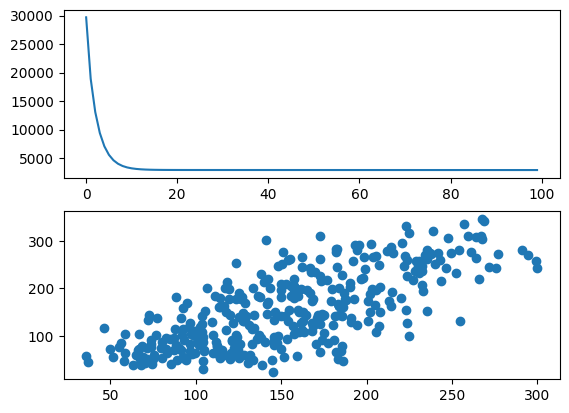

Parameter containing:
tensor([[  1.9400, -11.4488,  26.3047,  16.6306,  -9.8810,  -2.3179,  -7.6995,
           8.2121,  21.9769,   2.6065, 153.7365]], requires_grad=True)
Minimum cost: 2890.406494140625


In [ ]:
cost_lst = list()
model = LinearRegression(x_train.shape[1])
alpha = .1
for it in range(100):
  prediction = model(x_train)
  # print(prediction.shape)
  cost = mean_squared_error(y_train, prediction)
  cost_lst.append(cost.detach().numpy())
  gradient_descent_step(model, x_train, y_train, prediction, alpha)

fig, axs = plt.subplots(2)
axs[0].plot(list(range(it+1)), cost_lst)
print(prediction.shape,y_train.shape)
axs[1].scatter(prediction.detach().numpy(), y_train.detach().numpy())
plt.show()
print(model.weight)
print('Minimum cost: {}'.format(min(cost_lst)))

<font color="maroon">**Q5.** What conclusion if any can be drawn from the weight values? How does gender and BMI affect blood sugar levels?

What are the estimated blood sugar levels for the below examples? [2 marks] </font>

| AGE | SEX | BMI | BP  | S1  | S2    | S3 | S4  | S5     | S6  |
|-----|-----|-----|-----|-----|-------|----|-----|--------|-----|
| 25  | F   | 18  | 79  | 130 | 64.8  | 61 | 2   | 4.1897 | 68  |
| 50  | M   | 28  | 103 | 229 | 162.2 | 60 | 4.5 | 6.107  | 124 |

In [ ]:
x_new = torch.tensor([[25, 2, 18, 79, 130, 64.8, 61, 2, 4.1897, 68],
                      [50, 1, 28, 103, 229, 162.2, 60, 4.5, 6.107, 124]])

normalized_x_new, mu_train, sigma_train = norm_set(x_new)
x_new = normalized_x_new
x_new = torch.cat([x_new, torch.ones(x_new.shape[0], 1)], dim=1)


predictions_x_new = model(x_new)

# Convert predictions to NumPy array
predictions_np = predictions.detach().numpy()

# Print or use the predictions as needed
print('Predictions:', predictions_np)


Predictions: [[ 93.90104]
 [213.57202]]


*Now* estimate the error on the test set. Is the error on the test set comparable to that of the train set? What can be said about the fit of the model? When does a model over/under fits?


In [ ]:
prediction_test = model(x_test)
cost_test = mean_squared_error(y_test, prediction_test)

print("Cost test set", cost_test)

Cost test set tensor(2929.9829, grad_fn=<MeanBackward0>)


<font color="maroon">**Q6.** Try the code with a number of learning rates that differ by orders of magnitude and record the error of the training and test sets. What do you observe on the training error? What about the error on the test set? [3 marks]</font>

In [ ]:
cost_lst = list()

model = LinearRegression(x_train.shape[1])
alpha = [0.01, 0.001,0.0001]
cost_list_alpha = list()
cost_test_alpha = list()

for a in alpha:
    cost_lst = []  # Reset cost_lst at the beginning of each iteration
    for it in range(100):
        prediction = model(x_train)
        cost = mean_squared_error(y_train, prediction)
        cost_lst.append(cost.detach().numpy())
        gradient_descent_step(model, x_train, y_train, prediction, a)

    cost_list_alpha.append(cost_lst)
    prediction_test = model(x_test)
    cost_test = mean_squared_error(y_test, prediction_test)
    cost_test_alpha.append(cost_test.detach().numpy())


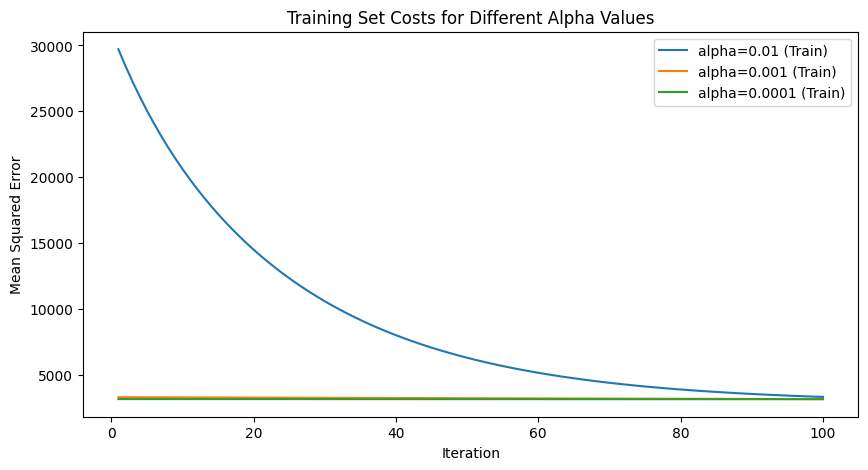

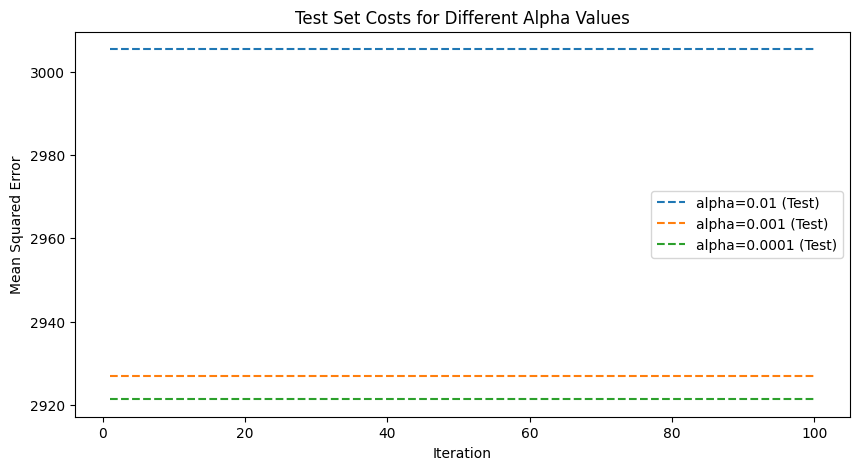

In [ ]:
plt.figure(figsize=(10, 5))
for i, costs in enumerate(cost_list_alpha):
    plt.plot(range(1, len(costs) + 1), costs, label=f'alpha={alpha[i]} (Train)')

plt.xlabel('Iteration')
plt.ylabel('Mean Squared Error')
plt.title('Training Set Costs for Different Alpha Values')
plt.legend()
plt.show()

# Plotting test set costs
plt.figure(figsize=(10, 5))
for i, cost_test in enumerate(cost_test_alpha):
    plt.plot(range(1, len(costs) + 1), [cost_test] * len(costs), linestyle='--', label=f'alpha={alpha[i]} (Test)')

plt.xlabel('Iteration')
plt.ylabel('Mean Squared Error')
plt.title('Test Set Costs for Different Alpha Values')
plt.legend()
plt.show()

# 1.2 Regularized Linear Regression
In this exercise, we will be trying to create a model that fits data that is clearly not linear. We will be attempting to fit the data points seen in the graph below:

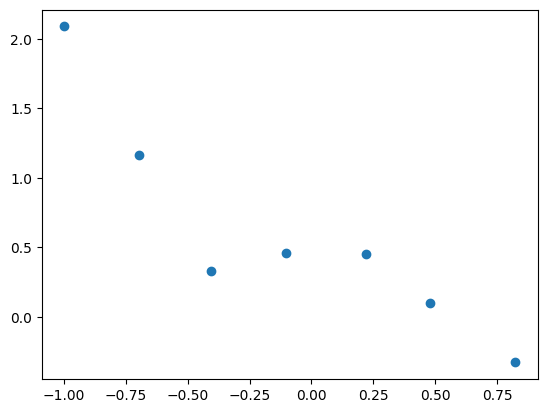

In [ ]:
x = torch.tensor([-0.99768, -0.69574, -0.40373, -0.10236, 0.22024, 0.47742, 0.82229]).reshape(-1, 1)
y = torch.tensor([2.0885, 1.1646, 0.3287, 0.46013, 0.44808, 0.10013, -0.32952]).reshape(-1, 1)
plt.scatter(x, y)
plt.show()

In order to fit this data we will create a new hypothesis function, which uses a fifth-order polynomial:

$
 h_{\theta}(x) = \theta_{0} x_{0} + \theta_{1} x_{1} + \theta_{2} x_{1} ^2 + \theta_{3} x_{1} ^3 + \theta_{4} x_{1} ^4 + \theta_{5} x_{1} ^5
$

As we are fitting a small number of points with a high order model, there is a danger of overfitting.  \\

To attempt to avoid this we will use regularization. Our cost function becomes:

$
 J(\theta) = \frac{1}{2m}  \left[ \sum_{i=1}^m ( h_{\theta}(x^{(i)}) - y^{(i)})^2 + \lambda    \sum_{j=1}^n \theta_{j}^2 \right]
$

Adjust variable `x` to include the higher order polynomials

In [ ]:
### your code here
### hint: remember to add x_0 for the bias
import numpy as np
import torch

m = len(y)

# Add x_0 for the bias term
X = torch.cat([torch.ones((m, 1)), x.view(-1, 1)], dim=1)

# Create higher order polynomials
for i in range(2, 6):
    X = torch.cat([X, (x**i).view(-1, 1)], dim=1)

# Now X contains the original features, as well as the higher order polynomials

# Initialize theta with zeros or random values
theta = torch.zeros((X.shape[1], 1), requires_grad=True)

# Set your regularization parameter
lambda_ = 0.1

# Set your learning rate and number of iterations
alpha = 0.01
num_iterations = 1000

# Cost function with regularization
def cost_function(theta, X, y, lambda_):
    m = len(y)
    h = X @ theta
    J = (1/(2*m)) * (torch.sum((h - y)**2) + lambda_ * torch.sum(theta[1:]**2))
    return J

# Gradient descent with regularization
def gradient_descent(theta, X, y, lambda_, alpha, num_iterations):
    m = len(y)
    for _ in range(num_iterations):
        h = X @ theta
        J = cost_function(theta, X, y, lambda_)
        J.backward()
        with torch.no_grad():
            theta -= alpha * theta.grad
            theta.grad.zero_()
    return theta.detach()

# Perform gradient descent
theta = gradient_descent(theta, X, y, lambda_, alpha, num_iterations)

# Now you have the optimized theta values
print(theta)


tensor([[ 0.3502],
        [-0.4845],
        [ 0.1794],
        [-0.4686],
        [ 0.2033],
        [-0.3953]])


**Q7.** Update the cost and gradient descent methods to use the regularised cost, as shown above. [4 marks]

Note that the punishment for having more terms is not applied to the bias. This means that we use a different update technique for the partial derivative of $\theta_{0}$, and add the regularization to all of the others:



$
 \theta_{j} =  \theta_{j} - \alpha \frac{1}{m} \sum_{i=1}^m ( h_{\theta}(x^{(i)}) - y^{(i)})x^{(i)}_{j} , j=0
$



$
 \theta_{j} =  \theta_{j} (1 - \alpha \frac{\lambda}{m}) -
 \alpha \frac{1}{m} \sum_{i=1}^m ( h_{\theta}(x^{(i)}) - y^{(i)})x^{(i)}_{j} , j>0
$

In [ ]:
import torch.nn as nn

def mean_squared_error(y_true: torch.Tensor, y_pred: torch.Tensor, lam: float, theta: torch.tensor) -> torch.Tensor:
    m = len(y_true)
    error = y_pred - y_true
    reg_term = (lam / (2 * m)) * torch.sum(theta[1:]**2)
    mse = torch.mean(error**2) + reg_term
    return mse

def gradient_descent_step(model: nn.Module, X: torch.Tensor, y: torch.Tensor, y_pred: torch.Tensor, lr: float, lam: float) -> None:
    weight = model.weight
    N = X.shape[0]

    error = y_pred - y

    # Ensure that grad has the same dimensions as X.T for matrix multiplication
    grad = X.T @ error.view(-1, 1) / N

    # Update theta_0 without regularization
    with torch.no_grad():
        weight[0] -= lr * grad[0].item()

    # Update theta_j (j > 0) with regularization
    with torch.no_grad():
        if grad[1:].numel() > 0:  # Check if grad[1:] has elements
            weight[1:] = (1 - lr * lam / N) * weight[1:] - lr * grad[1:].view(-1)


    model.weight = nn.Parameter(weight, requires_grad=False)



<font color="maroon"> **Q8.** First of all, find the best value of alpha to use in order to optimize best.
Next, experiment with different values of $\lambda$ and see how this affects the shape of the hypothesis. [3 marks]</font>

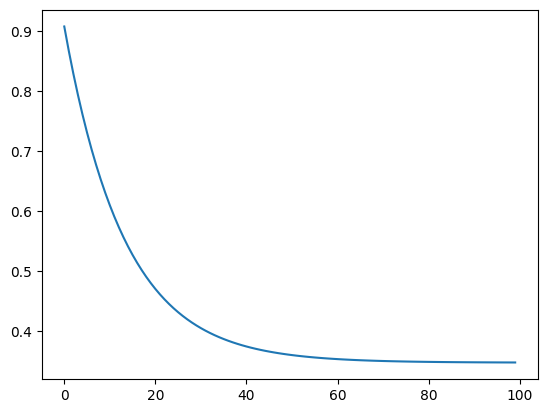

Parameter containing:
tensor([[-1.1998]])
Minimum cost: 0.34767231345176697


In [ ]:
cost_lst = list()
print(x.shape[0])
model = LinearRegression(x.shape[1])

alpha = 0.1 # select an appropriate alpha
lam = 0 # select an appropriate lambda
for it in range(100):
  prediction = model(x)
  cost = mean_squared_error(y, prediction, lam, model.weight)
  cost_lst.append(cost.detach().numpy())
  gradient_descent_step(model, x, y, prediction, alpha, lam)
display.clear_output(wait=True)
plt.plot(list(range(it+1)), cost_lst)
plt.show()
print(model.weight)
print('Minimum cost: {}'.format(min(cost_lst)))


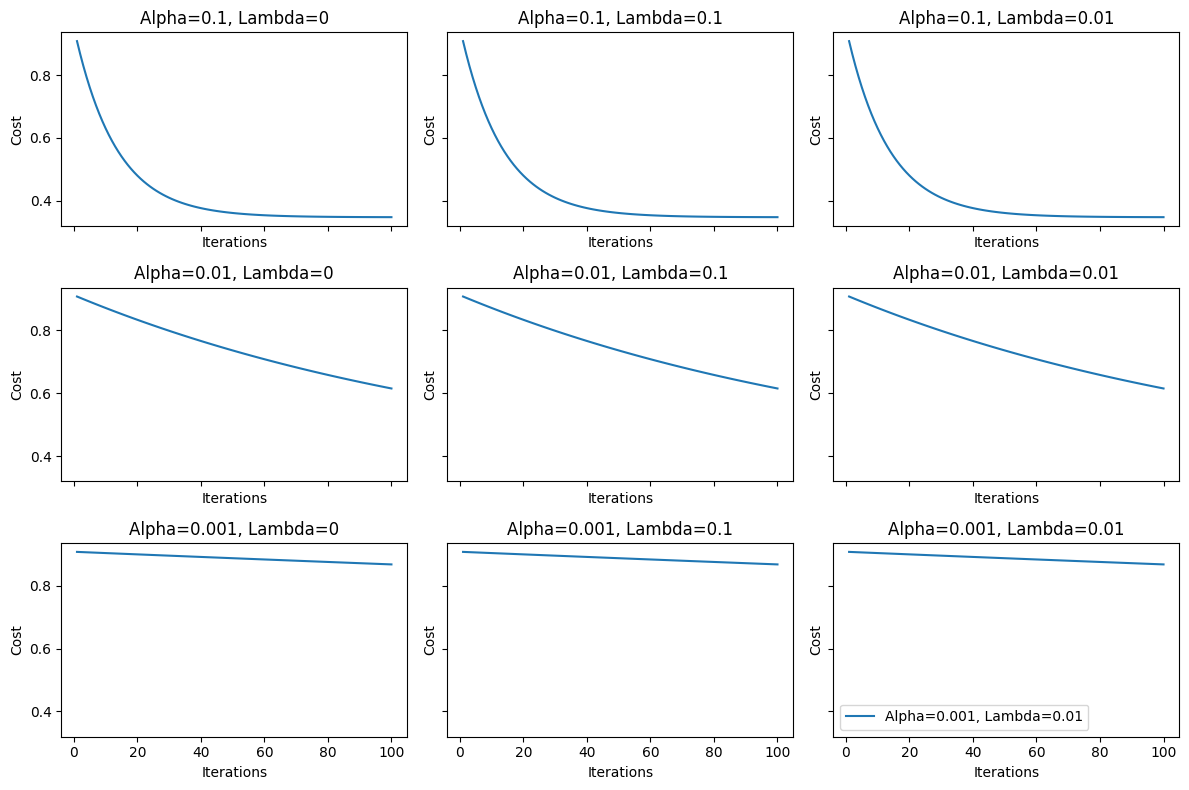

Best alpha: 0.1
Best lambda: 0
Minimum cost: 0.3476723


In [ ]:

## You can delete this block if you want
import itertools
import matplotlib.pyplot as plt

alpha_values = [ 0.1, 0.01, 0.001]
lambda_values = [0, 0.1, 0.01]

fig, axes = plt.subplots(len(alpha_values), len(lambda_values), figsize=(12, 8), sharex=True, sharey=True)

best_cost = float('inf')
best_alpha = None
best_lambda = None

for i, alpha in enumerate(alpha_values):
    for j, lam in enumerate(lambda_values):
        cost_lst = []
        model = LinearRegression(x.shape[1])

        for it in range(100):
            prediction = model(x)
            cost = mean_squared_error(y, prediction, lam, model.weight)
            cost_lst.append(cost.detach().numpy())
            gradient_descent_step(model, x, y, prediction, alpha, lam)

        axes[i, j].plot(range(1, len(cost_lst) + 1), cost_lst, label=f'Alpha={alpha}, Lambda={lam}')
        axes[i, j].set_title(f'Alpha={alpha}, Lambda={lam}')
        axes[i, j].set_xlabel('Iterations')
        axes[i, j].set_ylabel('Cost')

        final_cost = min(cost_lst)

        if final_cost < best_cost:
            best_cost = final_cost
            best_alpha = alpha
            best_lambda = lam

plt.legend()
plt.tight_layout()
plt.show()

print("Best alpha:", best_alpha)
print("Best lambda:", best_lambda)
print("Minimum cost:", best_cost)


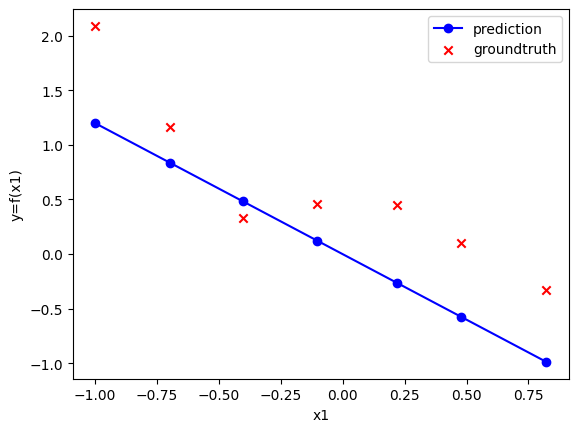

Model weight: Parameter containing:
tensor([[-1.1998]])
Minimum cost: 0.3476723


In [ ]:
x_values = x.detach().numpy().flatten()  # Flatten x_values to ensure it's 1D
outputs = model(x).detach().numpy().flatten()  # Flatten outputs
plt.plot(x_values, outputs, c='blue', marker='o', label='prediction')

plt.scatter(x_values, y.flatten(), c='red', marker='x', label='groundtruth')  # Flatten y for consistency
plt.xlabel('x1')
plt.ylabel('y=f(x1)')
plt.legend()
plt.show()

print("Model weight:", model.weight)
print('Minimum cost:', min(cost_lst))